In [149]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Model validation

In [150]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [151]:
data = np.load('../data/spectral_lines.npz')
X = data['spec']
y = data['target']

In [152]:
X.shape, y.shape

((1805, 778), (1805,))

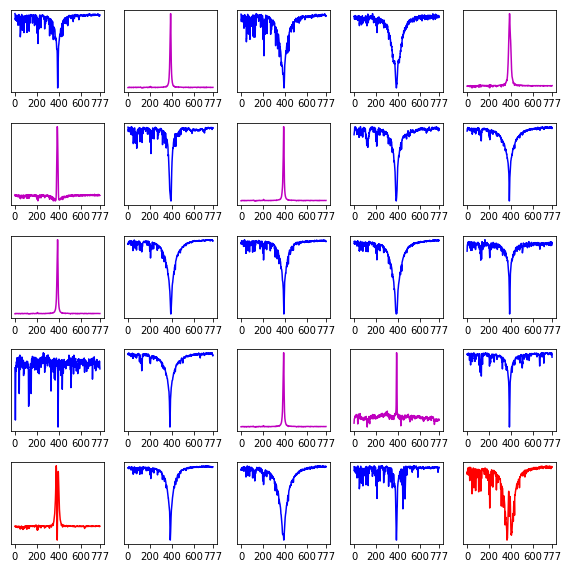

In [162]:
#Random 36 spectra from dataset
def get_color(x):
    return {
        1: 'm',
        2: 'g',
        3: 'b',
        4: 'r',
    }.get(x, 0)

plt.figure(figsize=(8,8))
for i, j in enumerate(np.random.permutation(X.shape[0])[200+50:200+75]):
    plt.subplot(5, 5, (i + 1))
    plt.plot(X[j], c=get_color(y[j]))
    plt.xticks(([0, 200, 400, 600, 777])), plt.yticks(())
    plt.tight_layout()

In [163]:
X=X[::3]
y=y[::3]

In [164]:
np.unique(y)

array([1., 2., 3., 4.])

In [172]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
np.unique(y)

array([0, 1, 2, 3])

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [166]:
clf = SVC(kernel='rbf', class_weight='balanced')

In [167]:
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [168]:
clf.score(X_test, y_test)

0.9536423841059603

# Cross-validation

In [169]:
cv = cross_val_score(clf, X, y, cv=5)
cv

array([0.8442623 , 0.80327869, 0.90082645, 0.93277311, 0.88135593])

In [170]:
cv.mean()

0.8724992942669273

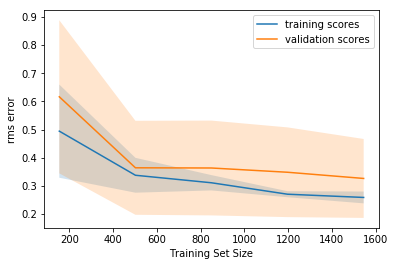

In [145]:
from sklearn.model_selection import learning_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
train_sizes = np.linspace(0.05, 1., 10)
N_train, val_train, val_test = learning_curve(clf, X, y, cv=7, scoring=rms_error, shuffle=True)
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('rms error')
plt.legend()

# Find a Bigger Hammer = Grid Search

In [83]:
svc_params = {
    'C': np.logspace(-2, 2, 5),
    'gamma': np.logspace(-4, 0, 5),
}

In [85]:
grid = GridSearchCV(clf, svc_params, cv=3)
grid.fit(X, y)
print(grid.best_params_, grid.best_score_)

({'C': 10.0, 'gamma': 0.001}, 0.9418604651162791)


/Users/toast/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [89]:
y_pred = grid.predict(X)
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

0.9850498338870431
              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98        79
         2.0       0.99      0.94      0.97        88
         3.0       1.00      1.00      1.00       418
         4.0       0.79      0.88      0.83        17

   micro avg       0.99      0.99      0.99       602
   macro avg       0.94      0.95      0.94       602
weighted avg       0.99      0.99      0.99       602



In [87]:
grid.score(X_test, y_test)

0.9867549668874173

In [88]:
clf = SVC(kernel='rbf', class_weight='balanced', 
         C=grid.best_params_['C'],
         gamma=grid.best_params_['gamma'])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9735099337748344